# Clustering 3K PBMCs with Variational Autoencoders

<img src="variational_autoencoder_model.png" width="800px" style="float:center">

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import os

from utils import plot_results_pca
from VAE3 import *

Using TensorFlow backend.


## Import dataset

In [2]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz -O data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz
!cd data; tar -xzf pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz

mkdir: cannot create directory ‘data’: File exists
--2019-06-13 09:46:46--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 143.204.247.31, 143.204.247.100, 143.204.247.106, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|143.204.247.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48700600 (46M) [application/x-tar]
Saving to: ‘data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz’

data/pbmc_10k_prote 100%[===================>]  46.44M  98.5MB/s    in 0.5s    

2019-06-13 09:46:46 (98.5 MB/s) - ‘data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz’ saved [48700600/48700600]



## Data preprocessing

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc10k.h5ad'

scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.15.4 scipy==1.2.0 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_10x_mtx(
   './data/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
   var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
   cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

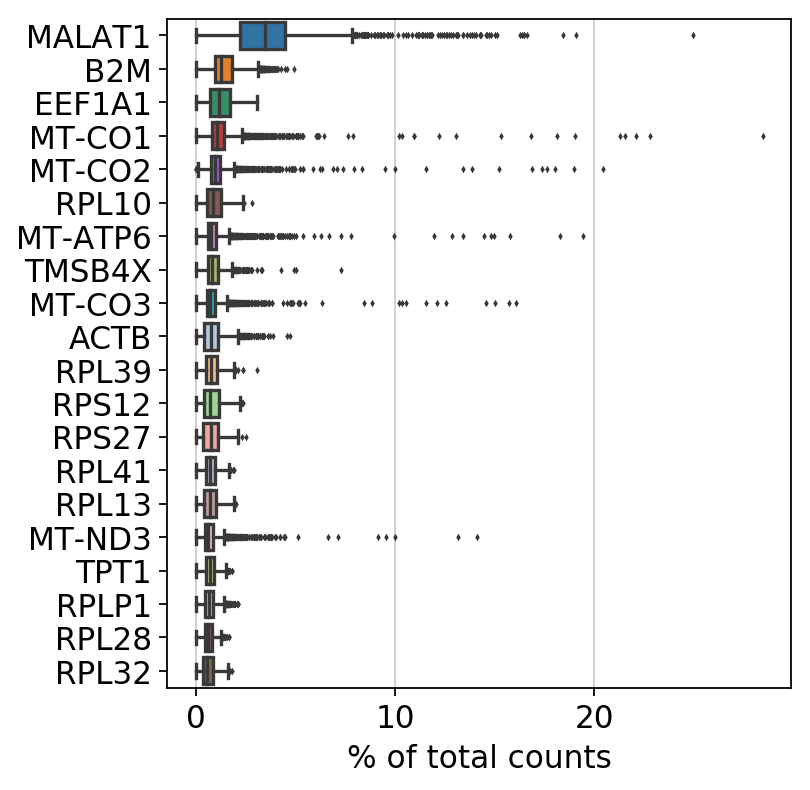

Trying to set attribute `.obs` of view, making a copy.


filtered out 9 cells that have less than 200 genes expressed
filtered out 15484 genes that are detected in less than 3 cells


In [7]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20)

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata = adata[adata.obs['n_genes'] < 2500, :]

In [8]:
# Data in log scale
sc.pp.log1p(adata)

In [9]:
adata.obs.shape

(7173, 1)

In [10]:
adata.obs.head()

n_genes
0                          
AAACCCAAGATTGTGA-1     2194
AAACCCACATCGGTTA-1     2093
AAACCCAGTACCGCGT-1     1518
AAACCCAGTATCGAAA-1      737
AAACCCAGTCGTCATA-1     1240

In [11]:
adata.var.shape

(18054, 3)

In [12]:
adata.var.head()

gene_ids    feature_types  n_cells
AL627309.1  ENSG00000238009  Gene Expression       12
AL669831.5  ENSG00000237491  Gene Expression      446
LINC00115   ENSG00000225880  Gene Expression      180
FAM41C      ENSG00000230368  Gene Expression      298
NOC2L       ENSG00000188976  Gene Expression     1547

In [13]:
adata.var_names

Index(['AL627309.1', 'AL669831.5', 'LINC00115', 'FAM41C', 'NOC2L', 'KLHL17',
       'PLEKHN1', 'AL645608.8', 'HES4', 'ISG15',
       ...
       'MT-CYB', 'BX004987.1', 'MAFIP', 'AC011043.1', 'AL592183.1',
       'AC007325.4', 'AL354822.1', 'AC004556.1', 'AC233755.1', 'AC240274.1'],
      dtype='object', length=18054)

In [14]:
gene_names = adata.var_names.values

In [15]:
data = adata.X.toarray()
#data = normalize(data, axis=-1, order=2)
print(np.any(np.isnan(data)))

False


In [16]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

## Variational Autoencoder Model

### Network parameters

In [17]:
original_dim = data.shape[1]

layer_1_dim = 100
layer_2_dim = 100
layer_3_dim = 100
batch_size = 128
latent_dim = 50
epochs = 125

In [18]:
encoder, decoder, vae = build_VAE(original_dim, latent_dim, layer_1_dim, layer_2_dim, layer_3_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 18054)        0                                            
__________________________________________________________________________________________________
DO (Dropout)                    (None, 18054)        0           X[0][0]                          
__________________________________________________________________________________________________
H1 (Dense)                      (None, 100)          1805400     DO[0][0]                         
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H1[0][0]                         
____________________________________________________________________________________________

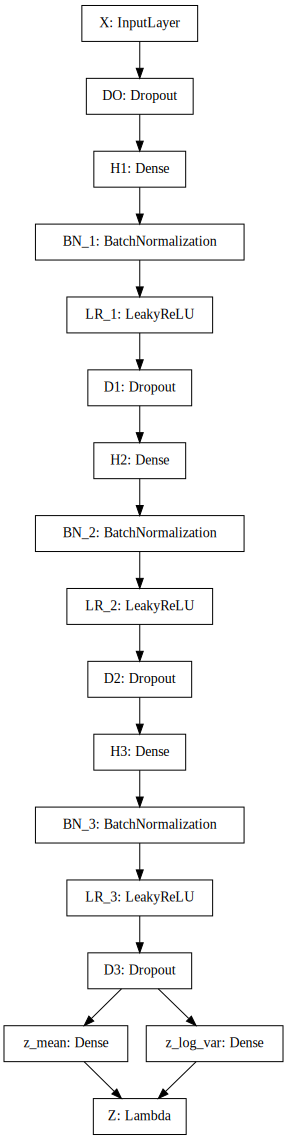

In [19]:
print("\nEncoder Network")
print("===============")
print(encoder.summary())
os.makedirs('img', exist_ok=True)
plot_model(encoder, to_file='img/vae_encoder.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))


Decoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 100)               5000      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 100)               400       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 100)               0         
_________________________________________________________________
D1 (Dropout)                 (None, 100)               0         
_________________________________________________________________
H2 (Dense)                   (None, 100)               1000

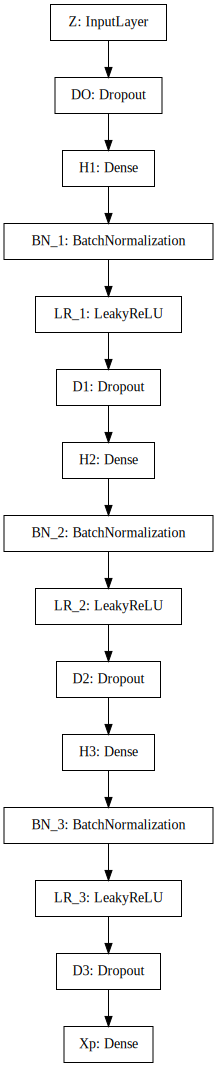

In [20]:
print("\nDecoder Network")
print("===============")
print(decoder.summary())
plot_model(decoder, to_file='img/vae_decoder.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))


Autoencoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 18054)             0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  1836700   
_________________________________________________________________
decoder (Model)              (None, 18054)             1849654   
Total params: 3,686,354
Trainable params: 3,685,154
Non-trainable params: 1,200
_________________________________________________________________


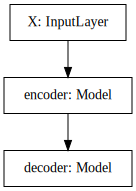

In [21]:
print("\nAutoencoder Network")
print("===================")
vae.summary()
plot_model(decoder, to_file='img/vae_autoencoder.png', show_shapes=True)
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

### Model training

In [22]:
vae_history = train_VAE(vae, data, batch_size, epochs)

# save model
os.makedirs('models', exist_ok=True)
vae.save_weights('models/vae_mnist.h5')

Instructions for updating:
Use tf.cast instead.
Train on 5738 samples, validate on 1435 samples
Epoch 1/125
5738/5738 [==============================] - 3s 598us/step - loss: 20386.9984 - val_loss: 19733.5226
Epoch 2/125
5738/5738 [==============================] - 2s 282us/step - loss: 18549.2909 - val_loss: 18258.3081
Epoch 3/125
5738/5738 [==============================] - 2s 294us/step - loss: 18201.4649 - val_loss: 17869.8072
Epoch 4/125
5738/5738 [==============================] - 2s 275us/step - loss: 18061.0764 - val_loss: 17776.8753
Epoch 5/125
5738/5738 [==============================] - 2s 275us/step - loss: 17993.9067 - val_loss: 17719.2144
Epoch 6/125
5738/5738 [==============================] - 2s 323us/step - loss: 17947.0178 - val_loss: 17694.8692
Epoch 7/125
5738/5738 [==============================] - 2s 306us/step - loss: 17911.1807 - val_loss: 17648.8290
Epoch 8/125
5738/5738 [==============================] - 2s 295us/step - loss: 17880.7692 - val_loss: 17630.8658


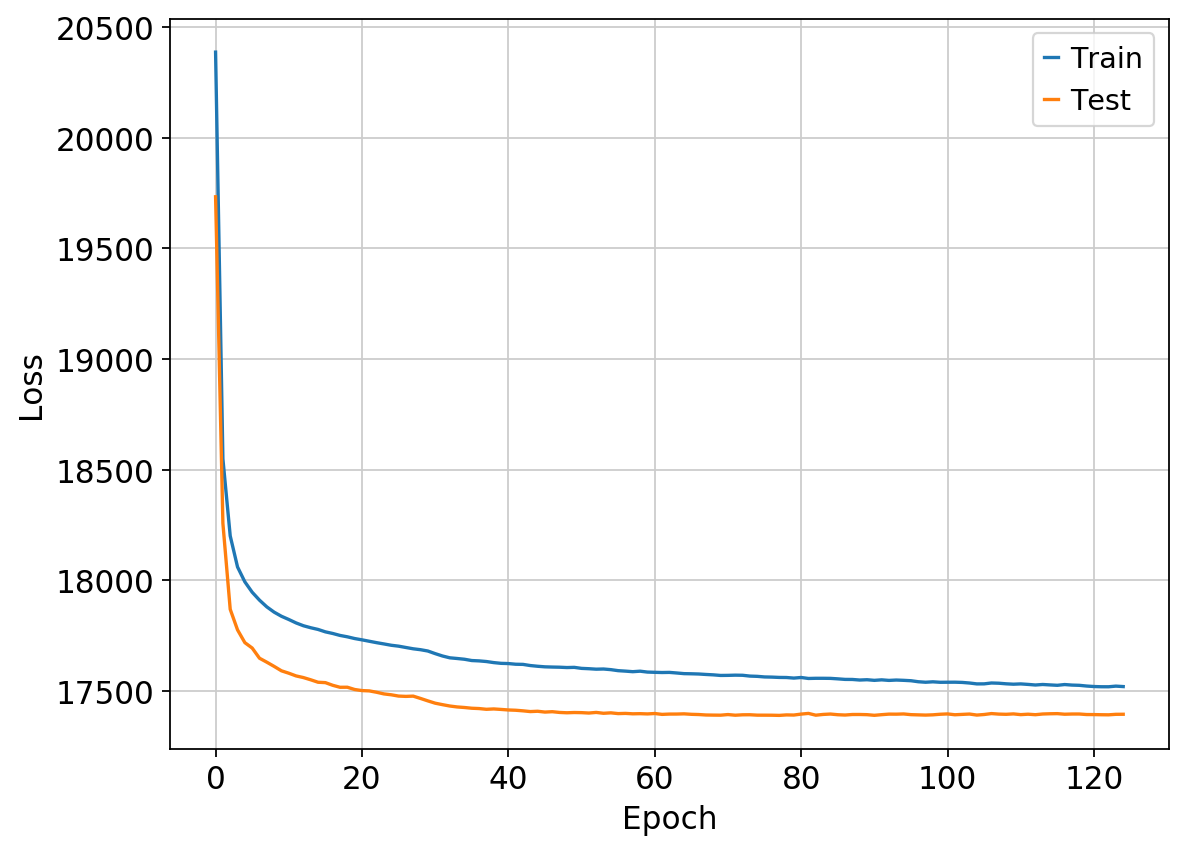

In [23]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(vae_history.history['loss'])
plt.plot(vae_history.history['val_loss'])
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([570,700])
#plt.loglog()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

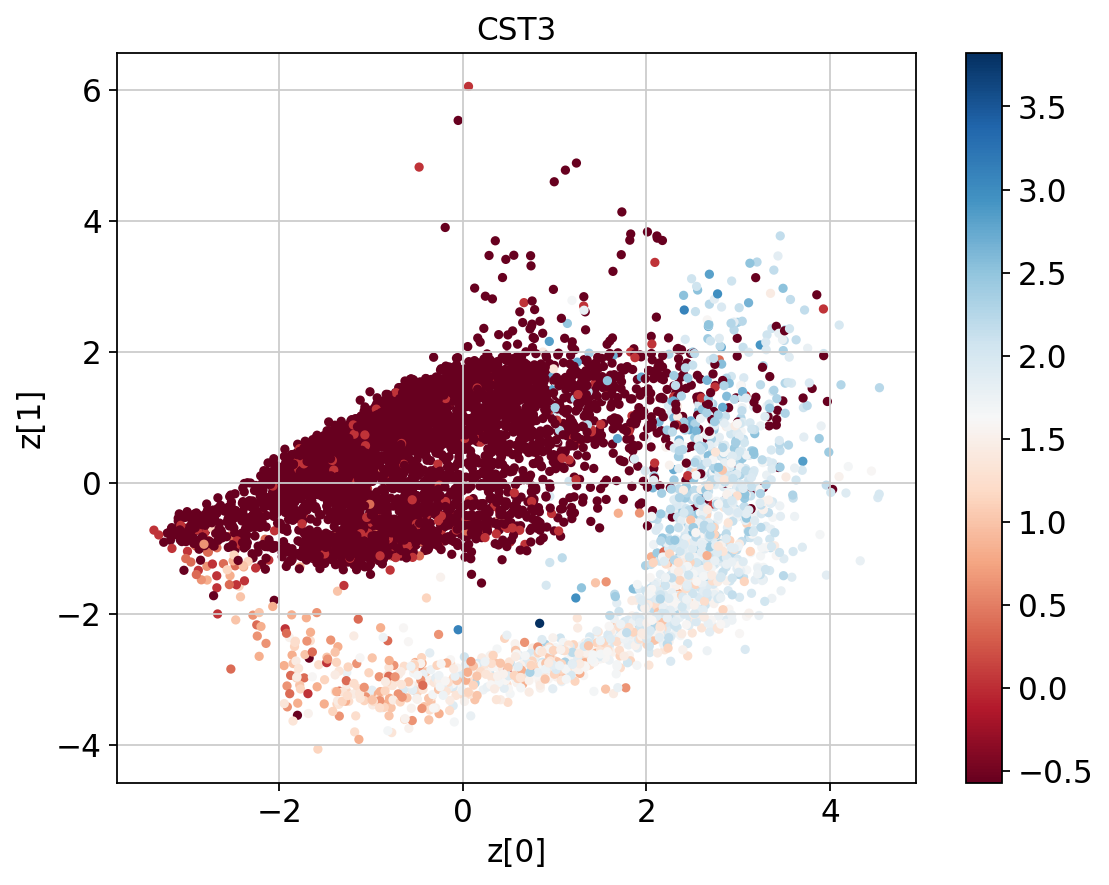

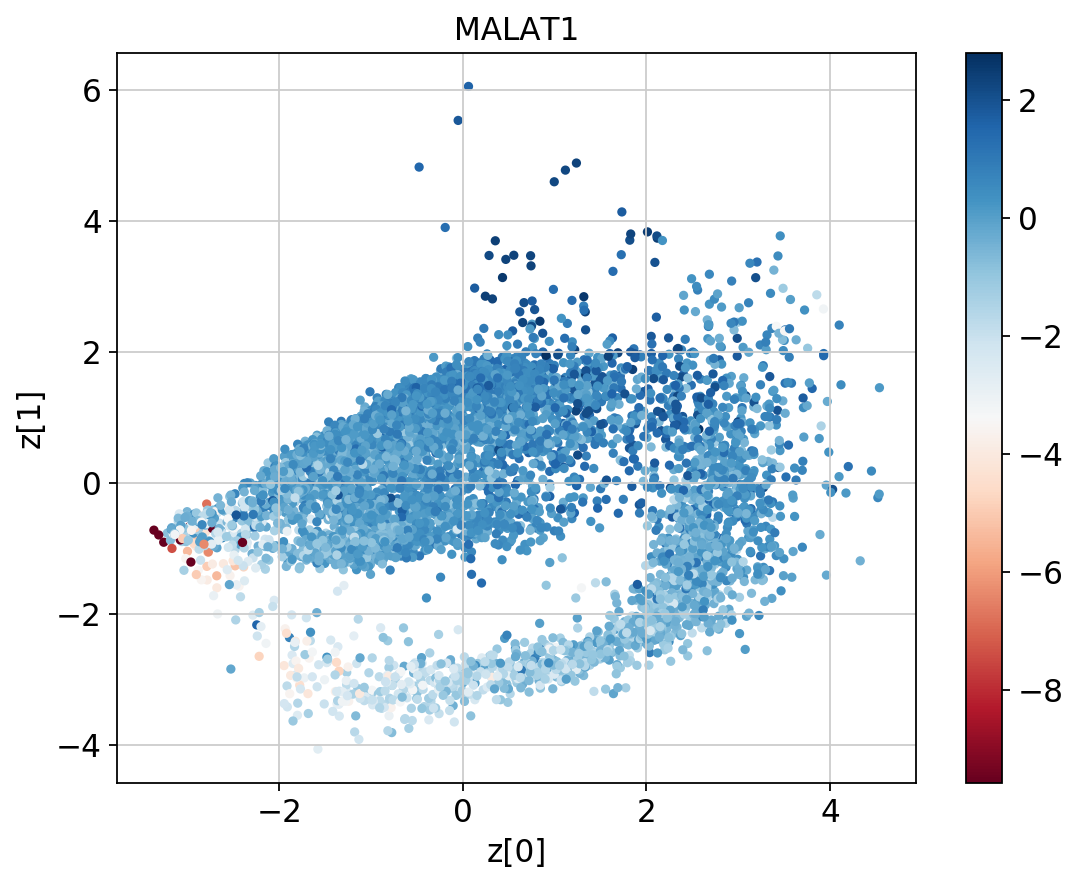

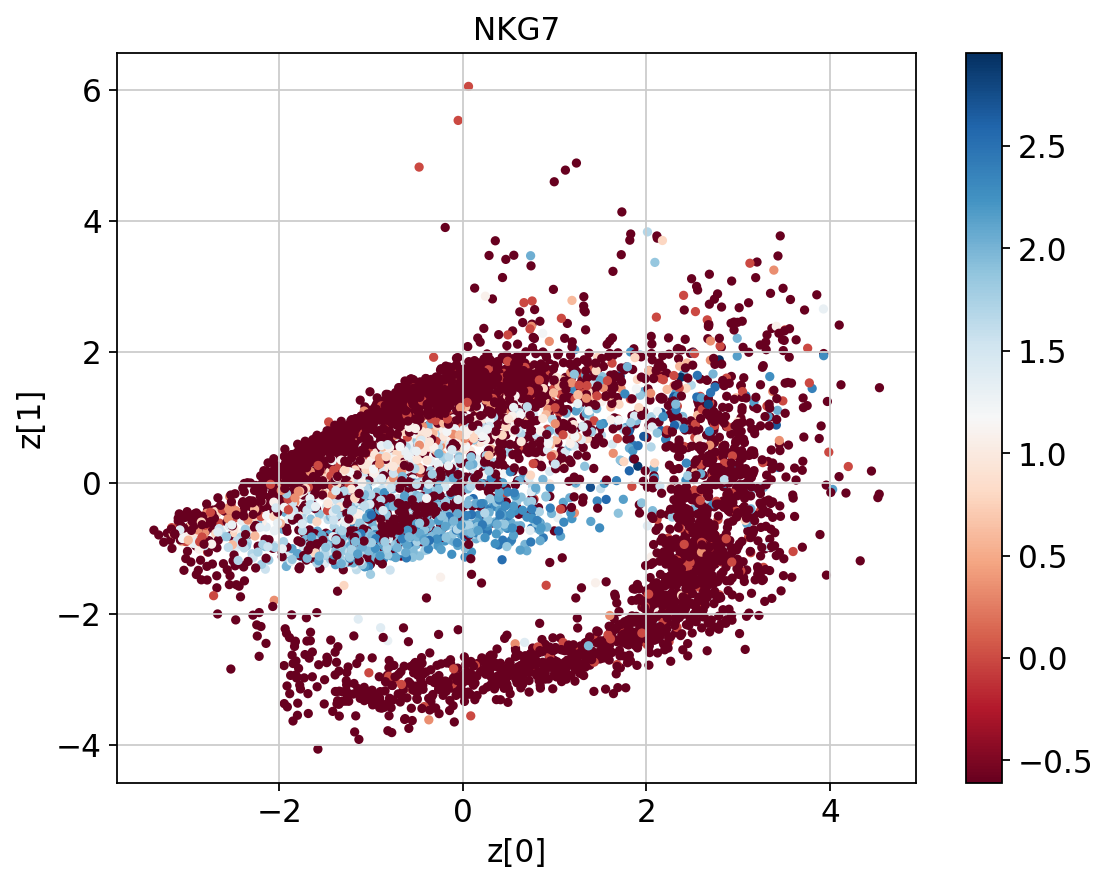

In [24]:
models = (encoder, decoder)
gene_list = ['CST3', 'MALAT1', 'NKG7']
plot_results_pca(models, data, gene_list, gene_names, latent_dim)